Importing the required libraries

In [25]:
import math
import time
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

import the data

In [68]:
heroes_info = pd.read_csv('./superhero-set//heroes_information.csv',index_col = 0)
heroes_powers = pd.read_csv('./superhero-set/super_hero_powers.csv')

In [69]:
heroes_info.head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,Abraxas,Male,blue,Cosmic Entity,Black,-99.0,Marvel Comics,-,bad,-99.0


In [70]:
heroes_info = heroes_info[heroes_info.Race != "-"]  # ignoring the super heroes with unknown race

In [71]:
heroes_info['Human'] = heroes_info['Race'].apply(lambda i: 1 if i == 'Human' else 0) # creating the label

# Data Preprocessing

In [72]:
heroes_info.columns[heroes_info.isnull().any()]  # checking for null values

Index(['Publisher', 'Weight'], dtype='object')

In [73]:
def null_count(df,col):
    '''
    checking for unnecessary values in the dataset like -, -99.0
    df : dataframe
    col : column
    '''
    null_symbols = ["-",-99.0]
    per = 0
    for i in null_symbols:
        if i in df[col].value_counts():
            if df[col].isnull().sum() > 0:  # checking for null value
                per = ((df[col].value_counts()[i] + df[col].isnull().sum() ) / len(df)) *100
                break
            else:
                per = (df[col].value_counts()[i] / len(df)) *100
                break
        else:
            continue
    return per

In [34]:
cols = ['Gender', 'Eye color', 'Hair color',
       'Height', 'Publisher', 'Skin color', 'Alignment', 'Weight']

In [35]:
removable_columns = []
for i in cols:
    if null_count(heroes_info,i) > 50:  # Removing the columns that have more than 50% of junk records 
        removable_columns.append(i)

In [36]:
removable_columns

['Skin color']

In [37]:
heroes_info.drop(['Skin color','Race'],axis=1,inplace=True)  # droping the skin colour and race columns

In [38]:
heroes_info.describe(include=["O"])   # Descriptive stats of categorical features

,name,Gender,Eye color,Hair color,Publisher,Alignment
count,430,430,430,430,430,430
unique,420,3,21,22,19,4
top,Spider-Man,Male,blue,Black,Marvel Comics,good
freq,3,321,147,106,223,279


In [39]:
heroes_info.describe()  # Descriptive stats of continous features

,Height,Weight,Human
count,430.000000,430.000000,430.000000
mean,188.712791,109.155814,0.483721
std,62.627992,94.114894,0.500317
min,15.200000,4.000000,0.000000
25%,178.000000,74.000000,0.000000
50%,183.000000,83.000000,0.000000
75%,188.000000,99.000000,1.000000
max,975.000000,855.000000,1.000000


In [40]:
heroes_info['Weight'].fillna(heroes_info['Weight'].median(), inplace=True) # Filling null values with median
heroes_info['Publisher'].fillna(heroes_info['Publisher'].mode()[0], inplace=True) # Filling null values with median

In [41]:
from sklearn.preprocessing import Imputer      # Imüuting the missing values

imp = Imputer(missing_values=-99.0, strategy='median', axis=0)
heroes_info["Height"]=imp.fit_transform(heroes_info[["Height"]])
heroes_info["Weight"]=imp.fit_transform(heroes_info[["Weight"]])

Exploratory data analysis

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


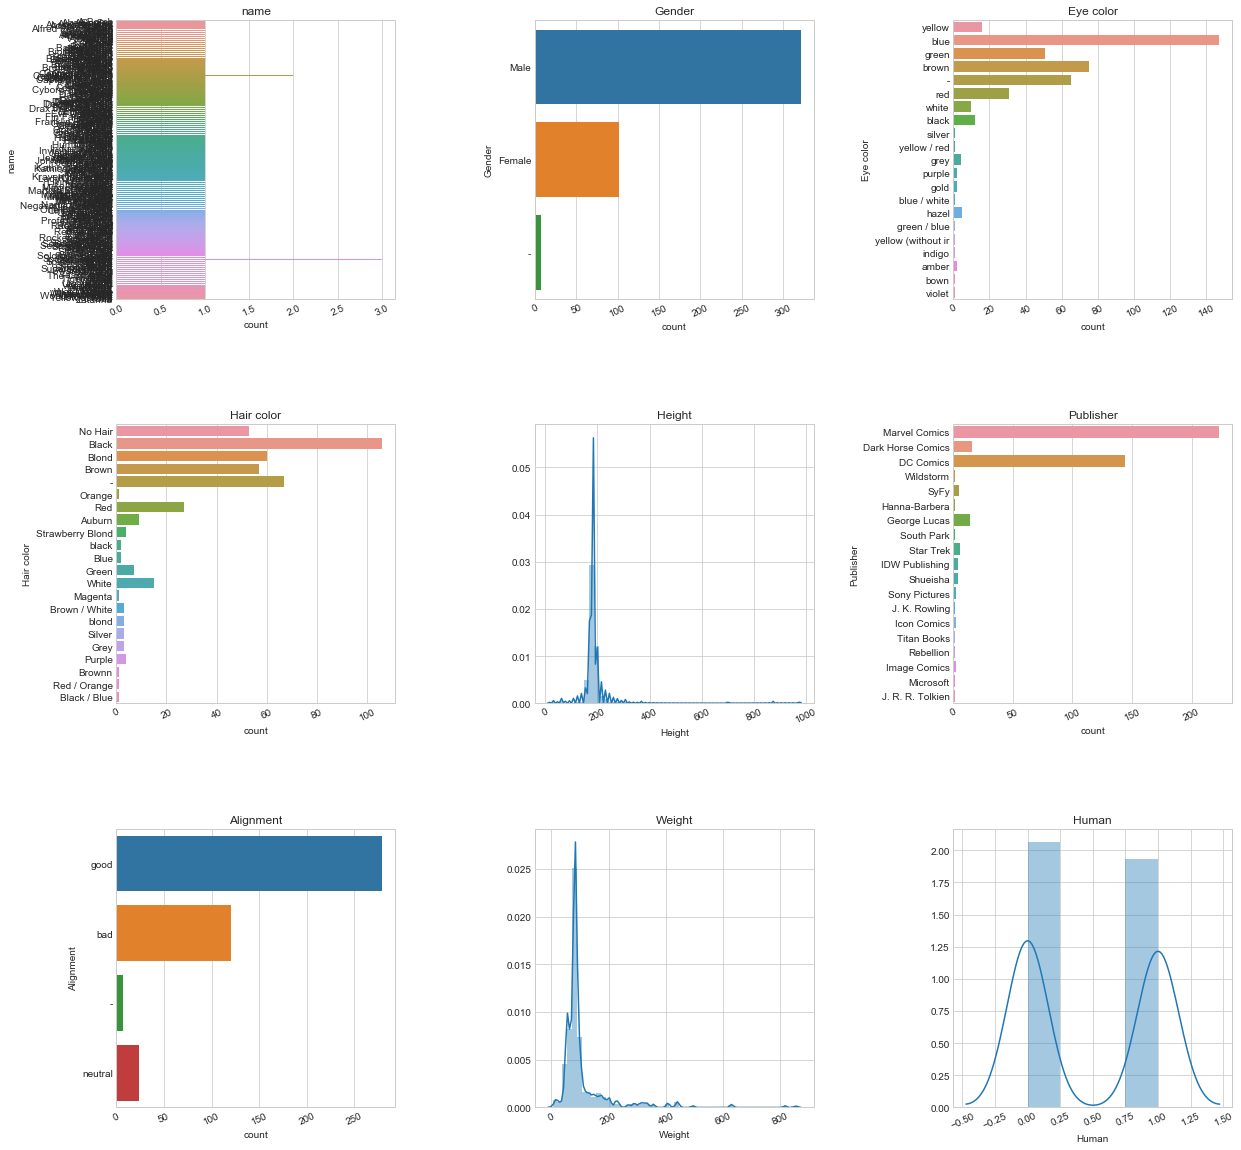

In [42]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(heroes_info, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

From the above distributions we can understand that for few of the features there are too many categorical values
and when we create dummy variables from these it would create too many dimensions. To avoid that we can generalize 
the dimensions by grouping similar items into one category. For instance in Publisher feature we can reduce the dimensions into 3 broad categories (Marvel, DC and Others).

In [43]:
heroes_powers = heroes_powers * 1    # Converting True , False in the dataframe features to numericals(1 and 0)

In [44]:
dataset = pd.merge(heroes_info, heroes_powers, left_on=['name'], right_on=['hero_names'], how='inner') # Joining the two datasets

In [45]:
from sklearn.preprocessing import LabelEncoder   # Encoding the categorical columns
cols = ['Gender', 'Eye color', 'Hair color', 'Publisher', 'Alignment']

dataset[cols] = dataset[cols].apply(LabelEncoder().fit_transform)

In [46]:
X_columns_drop = ['name', 'hero_names', 'Human']     # Dropping the features which are note required for development of model and the target label
X, y = dataset.drop(X_columns_drop, axis=1), dataset['Human']

In [47]:
from sklearn.model_selection import train_test_split  # Splitting the dataset for testing purposes
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42,stratify=y)

# Model Building

In [48]:
# Fit the ml algorithm on the datasets
def fit_algo(algo, X_train, y_train, X_test, cv):
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]

    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return model, train_pred, test_pred, acc, acc_cv, probs

# calculate the auc value
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [50]:
#  DecisionTreeClassifier
start_time = time.time()
model_dt, train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 66.27
Accuracy CV 10-Fold: 67.88
Running Time: 0:00:06.100796


In [75]:
#  RandomForestClassifier
start_time = time.time()
model_rf, train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_algo(RandomForestClassifier(n_estimators=100), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 68.67
Accuracy CV 10-Fold: 77.88
Running Time: 0:00:06.068400


Train data :
              precision    recall  f1-score   support

          0       0.78      0.82      0.80       174
          1       0.78      0.74      0.76       156

avg / total       0.78      0.78      0.78       330

Test data : 
              precision    recall  f1-score   support

          0       0.70      0.73      0.71        44
          1       0.68      0.64      0.66        39

avg / total       0.69      0.69      0.69        83



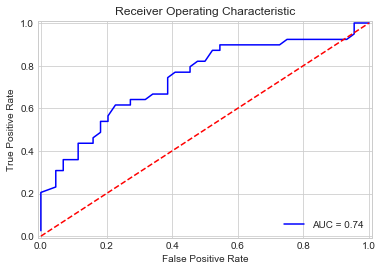

In [76]:
print('Train data :\n', metrics.classification_report(y_train, train_pred_rf))
print('Test data : \n', metrics.classification_report(y_test, test_pred_rf))
plot_roc_curve(y_test, probs_rf)

In [53]:
#Naive Bayes
start_time = time.time()
model_nb, train_pred_nb, test_pred_nb, acc_nb, acc_cv_nb, probs_nb = fit_algo(GaussianNB(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_nb)
print("Accuracy CV 10-Fold: %s" % acc_cv_nb)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 61.45
Accuracy CV 10-Fold: 64.24
Running Time: 0:00:05.992384


In [54]:
#GradientBoostingClassifier
start_time = time.time()
model_gb, train_pred_gb, test_pred_gb, acc_gb, acc_cv_gb, probs_gb = fit_algo(GradientBoostingClassifier(n_estimators=100), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gb)
print("Accuracy CV 10-Fold: %s" % acc_cv_gb)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 60.24
Accuracy CV 10-Fold: 78.18
Running Time: 0:00:06.314523


In [77]:
models = pd.DataFrame({
    'Model': [ 
              'Random Forest', 'Naive Bayes', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [ 
        acc_rf, 
        acc_nb,  
        acc_dt,
        acc_gb
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Random Forest,68.67
2,Decision Tree,66.27
1,Naive Bayes,61.45
3,Gradient Boosting Trees,60.24


From the above table we can observe that Random forest is performing sligtly better than other models with almost 
67% test accuracy

# Hyperparameter Tuning

In [63]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)] # Number of trees in random forest # Number of features to consider at every split
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]# Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500]}


In [64]:
rf = RandomForestClassifier()  # First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train) # Fit the random search model

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   38.3s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [65]:
 rf_random.best_params_   # Finding the best parameters

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'bootstrap': False}

In [66]:
best_random = rf_random.best_estimator_    # Finding the best estimator

In [67]:
#  RandomForestClassifier
start_time = time.time()
model_rf, train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_algo(best_random, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 61.45
Accuracy CV 10-Fold: 78.48
Running Time: 0:00:07.181925


In this scenario Random search doesn't tuned well. One should carefully tune these parameters by considering various scnarios.

# Important features

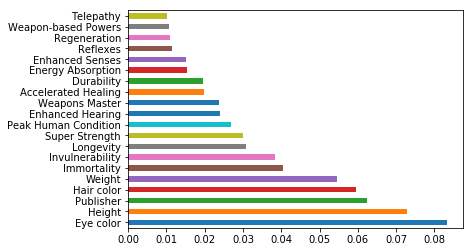

In [317]:
feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [28]:
import pandas  #test